In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 
## Homework 4: Classification: Predicting College Admissions

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
# RUN THIS CELL
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data exploration using train and basic models**](#part1)

- [**Question 2: Interpretable modeling**](#part2)

- [**Question 3: Harvard and Yale?**](#part3)

- [**Question 4: Building predictive models for admitted**](#part4)

- [**Question 5: Evaluating results**](#part5)

- [**Question 6: BONUS!**](#part6)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting admissions into elite universities

In this problem set we will model the chances of high school students being accepted into two different elite undergraduate colleges: Harvard and Yale.

The data are provided in the file `data/college_admissions.csv` and were scraped in 2022 from [collegedata.com](https://www.collegedata.com/) (where applicants volunteer to share their information).  Each observation corresponds to an applicant to one of the two different colleges (note: the same applicant may show up in two rows: once for each college).  The main response is the `"admitted"` variable (1 = admitted, 0 = denied), and there are are several predictors to consider:

- **id**: a unique identifier for the applicant 
- **test_score**: a standardized measurement of the applicant's highest ACT or SAT combined score (2400 is the maximum)
- **ap**: the number of AP tests taken
- **avg_ap**: the average score on the AP tests taken (0 if no tests were taken)
- **sat_subjects**: the number of SAT subject tests taken
- **gpa**: the unweighted GPA of the applicant (max of 4.0)
- **female**:  a binary indicator for gender: 1 = female, 0 = otherwise
- **minority**: a binary indicator for under-represented minority: 1 = minority, 0 = otherwise 
- **international**: a binary indicator for international status: 1 = international, 0 = United States
- **sports**: a binary indicator for High School All-American: 1 = all-American athlete, 0 = otherwise
- **harvard**: a categorical variable for school applied to: 1 = Harvard, 0 = Yale
- **early_app**: a binary indicator for application type: 1 = early action, 0 = regular
- **alumni**:  a binary indicator for parents' alumni status of school: 1 = a parent is an alumnus, 0 = otherwise
- **program**: the program applied to by the student with many choices (we will not use this as a predictor)
- **add_info**: additional (optional) info provided by applicant (we will not use this as a predictor)

**The main set of 12 predictors is:**

```python
[
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]
```

Please note, you may need to modify this list when fitting different models.


**IMPORTANT NOTES:**

- Unless stated otherwise, all logistic regression models should be unregularized (use `penalty=None`) and include the intercept (which is the default in `sklearn`).


- When printing your output (e.g. coefficients, accuracy scores, etc.), DO NOT just print numbers without context. Please be certain provide clarifying labels for all printed numbers and limit the number of digits showing after decimals to a reasonable length (e.g. 4 decimal points for coefficients and accuracy scores).


- Also be sure to practice good data science principles: always use train to do analysis and never touch the test set until the very end.

---

<a id="part1"></a>

## <div class='exercise'>Question 1: Data exploration using train and basic models</div>

[Return to contents](#contents)

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. 

**IMPORTANT:** While an argument could be made to scale our predictors here, please **DO NOT** do so **UNTIL** it is requested of you in **[Question 4.1](#part4)**.


In [5]:
#############################
## DO NOT MODIFY THIS CODE ##
#############################
np.random.seed(121)

college = pd.read_csv("data/college_admissions.csv")

college_train, college_test = train_test_split(
    college,
    test_size=0.2,
    random_state=121,
    shuffle=True,
    stratify=college["admitted"],
)

print(college.shape)
print(college_train.shape, college_test.shape)
display(college_train.head())
college_train.info()

# Separate predictors from response
X_train, y_train = college_train.drop(columns=["admitted"]), college_train["admitted"]
X_test, y_test = college_test.drop(columns=["admitted"]), college_test["admitted"]

(1871, 16)
(1496, 16) (375, 16)


,id,admitted,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,program,add_info,harvard
192,NYFN0GE0KK,1,2310,7,5.000,5,3.98,0,0,0,0,0,0,Economics,Activities Activity Position Honors Grade Levels Approximate Time When Participated Participate ...,1
652,50FWDZ3MBF,1,2010,3,4.333,3,3.75,1,1,0,0,0,0,History Political Science,Drama Club Co founder of a Community Outreach Organization called Los Amigos volunteered helped ...,1
593,KYYHQRHBV9,0,2080,5,4.200,2,3.85,0,0,0,0,0,0,Biology Pre Med,moderate a few sports and clubs and a part time jobfamily circumstances positive,1
331,JQ8O4AV4VM,0,2250,0,0.000,2,4.00,0,0,0,0,0,0,Physics,NaN,1
1117,SJUQZVBA7K,0,2230,4,4.000,5,3.96,1,0,0,0,1,0,Chemistry Chemical Engineering,MUN Advisor 12 10 National Honors Society 12 10 California Scholarship Federation 12 9 Book Club...,0


<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 192 to 1296
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1496 non-null   object 
 1   admitted       1496 non-null   int64  
 2   test_score     1496 non-null   int64  
 3   ap             1496 non-null   int64  
 4   avg_ap         1496 non-null   float64
 5   sat_subjects   1496 non-null   int64  
 6   gpa            1496 non-null   float64
 7   female         1496 non-null   int64  
 8   minority       1496 non-null   int64  
 9   international  1496 non-null   int64  
 10  sports         1496 non-null   int64  
 11  early_app      1496 non-null   int64  
 12  alumni         1496 non-null   int64  
 13  program        1298 non-null   object 
 14  add_info       949 non-null    object 
 15  harvard        1496 non-null   int64  
dtypes: float64(2), int64(11), object(3)
memory usage: 198.7+ KB


<div class='exercise-r'>

**Q1.1** Consider a baseline, "naive" model that predicts that *ALL* applicants belong to the same class. This class prediction is *not* determined by an applicant's feature values, but rather by the proportion of observations in the training data belonging to each class.

Calculate the accuracy of this naive model on the training data and store it in `naive_train_acc`.
    
**NOTE:** For this assignment, use the convention that accuracies range from 0 to 1 (to be consistant with sklearn).
    
</div>

In [6]:
# Calculate the proportion of admitted students in training data
prop_admitted = y_train.mean()

# The naive model will predict the majority class for everyone
naive_prediction = 1 if prop_admitted > 0.5 else 0

# Calculate accuracy - it will be max(prop_admitted, 1-prop_admitted)
naive_train_acc = max(prop_admitted, 1 - prop_admitted)

In [7]:
print("Naive Classification Model Based on Training Proportions")
print(f"\tTrain Accuracy: {naive_train_acc:.4f}")

Naive Classification Model Based on Training Proportions
	Train Accuracy: 0.7299


In [8]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.2** Let's investigate how each of our 12 predictors is associated with whether or not an applicant is admitted into the college to which they applied (`admitted`). To this end, create a separate **visual** for each of our predictors to investigate their relationship with college admissions. **Suggestion:** Place these 12 visuals in a grid of subplots with 3 columns and 4 rows.

</div>

In [9]:
# Create dummy variable
# your code here
...

Ellipsis

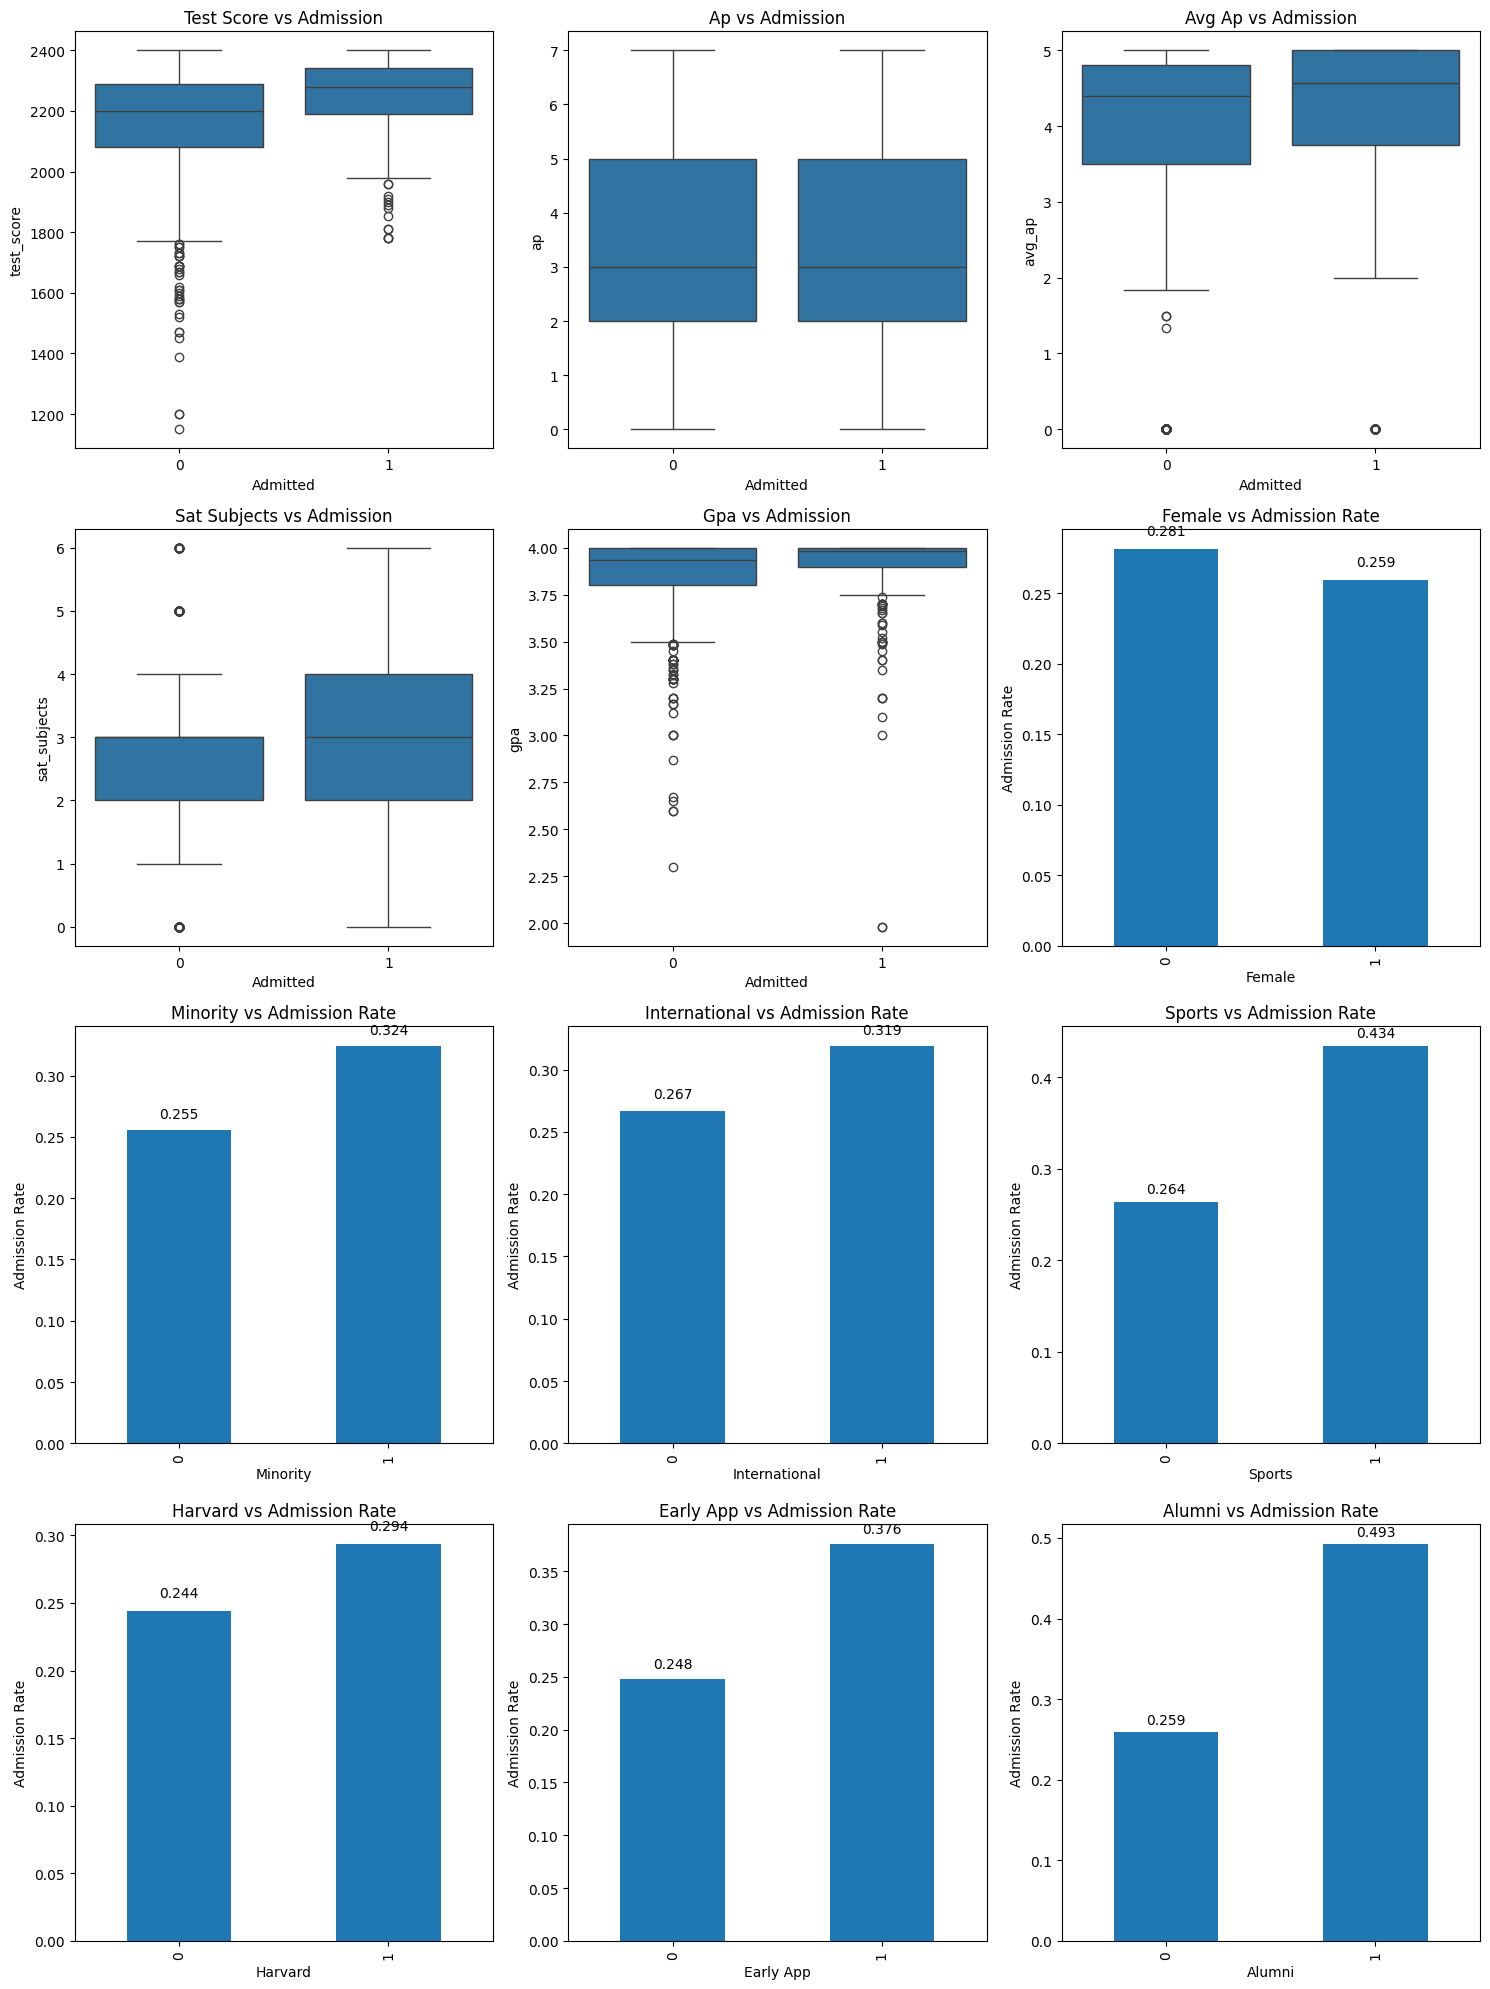

In [10]:
# Plotting
# your code here


fig, axes = plt.subplots(4, 3, figsize=(15, 20))

# Flatten axes for easier iteration
axes = axes.flatten()


numeric_vars = ['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa']
binary_vars = ['female', 'minority', 'international', 'sports', 'harvard', 'early_app', 'alumni']

#counter
plot_idx = 0

# Plot numeric variables using box plots
for var in numeric_vars:
    sns.boxplot(data=college_train, x='admitted', y=var, ax=axes[plot_idx])
    axes[plot_idx].set_title(f'{var.replace("_", " ").title()} vs Admission')
    axes[plot_idx].set_xlabel('Admitted')
    plot_idx += 1

# Plot binary variables using bar plots
for var in binary_vars:
    # Calculate admission rates for each category
    admission_rates = college_train.groupby(var)['admitted'].mean()
    admission_rates.plot(kind='bar', ax=axes[plot_idx])
    axes[plot_idx].set_title(f'{var.replace("_", " ").title()} vs Admission Rate')
    axes[plot_idx].set_xlabel(var.replace("_", " ").title())
    axes[plot_idx].set_ylabel('Admission Rate')
    # Add value labels on bars
    for i, v in enumerate(admission_rates):
        axes[plot_idx].text(i, v + 0.01, f'{v:.3f}', ha='center')
    plot_idx += 1


# Adjust layout to prevent overlap
plt.tight_layout()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**1.3** Based on the visuals above, which predictor seems to have the most potential for predicting `admitted`? Why do you think this it the best potential single predictor?
    


</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Somewhat naively, I will say that alumni presence vs admission rate is the greatest predictor for admitted because the dicference between the 0 and 1 for admitted stratified based on this group is the largest of any group. I am not completely confident in this interpretation because I have not evaluated the strength of our measurements or the observations. I have not done any hypothesis testing or credible interval creation.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>
    
**Q1.4** Fit a logistic regression to predict `admitted` from `harvard` (call it `logit1_4`).  
- Store the coefficient and intercept in `logit1_4_coef` and `logit1_4_intercept`. Interpret these values.
- Use $\LaTeX$ to demonstrate how you can use these coefficient values to calculate the estimated probabilities of getting into each school.
- Store the results of the above calculation in `p_harvard` and `p_yale`. 
- Which school is easier to get into according to this model?

**IMPORTANT:** 
- Remember, all models in this assignment should be **unregularized** unless you are specifically asked to use regularization for a particular model.
- Use `random_state = 109` for all of your `LogisticRegression` and `LogisticRegressionCV` models in this notebook.
</div>

In [11]:
# your code here
...
logit1_4 = LogisticRegression(penalty=None, random_state=109)
logit1_4.fit(X_train[['harvard']], y_train)

# Extract coefficient and intercept
logit1_4_coef = logit1_4.coef_[0][0]
logit1_4_intercept = logit1_4.intercept_[0]

# yale
p_yale = 1 / (1 + np.exp(-(logit1_4_intercept)))

# For Harvard (harvard = 1):
p_harvard = 1 / (1 + np.exp(-(logit1_4_intercept + logit1_4_coef)))

print("Model Parameters:")
print(f"Coefficient (harvard): {logit1_4_coef:.4f}")
print(f"Intercept: {logit1_4_intercept:.4f}")

Model Parameters:
Coefficient (harvard): 0.2512
Intercept: -1.1280


In [12]:
print(
    "The coefficient for the 'logit1_4' model's only predictor 'harvard' "
    "is {:.4f} and the intercept is {:.4f}\n".format(
        logit1_4_coef, logit1_4_intercept
    )
)

print(
    "Estimated probability of acceptance for Harvard: {:.4f}"
    .format(p_harvard)
)
print(
    "Estimated probability of acceptance for Yale: {:.4f}"
    .format(p_yale)
)

The coefficient for the 'logit1_4' model's only predictor 'harvard' is 0.2512 and the intercept is -1.1280

Estimated probability of acceptance for Harvard: 0.2938
Estimated probability of acceptance for Yale: 0.2445


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [13]:
grader.check("q1.4")

q1.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.5** Create and display a [contingency table](https://en.wikipedia.org/wiki/Contingency_table) between `admitted` and `harvard`.  Use this table to calculate and confirm the coefficient estimates in the `logit1_4` model (both the intercept and slope). Show this calculation using $\LaTeX$ in a markdown cell.
    
**Hint:** The Pandas [crosstab](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) method may be helpful here.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

For Yale (harvard = 0):

$p_0 = \frac{\text{Yale admitted}}{\text{Total Yale applicants}} = \frac{176}{544 + 176} = \frac{176}{720} = 0.244$

$\beta_0 = \ln\left(\frac{p_0}{1-p_0}\right) = \ln\left(\frac{0.244}{0.756}\right) = -1.1285$

For Harvard (harvard = 1):

$p_1 = \frac{\text{Harvard admitted}}{\text{Total Harvard applicants}} = \frac{228}{548 + 228} = \frac{228}{776} = 0.294$

$\ln\left(\frac{p_1}{1-p_1}\right) = \ln\left(\frac{0.294}{0.706}\right) = -0.8770$

The coefficient $\beta_1$ is the difference:

$\beta_1 = \ln\left(\frac{p_1}{1-p_1}\right) - \ln\left(\frac{p_0}{1-p_0}\right) = -0.8770 - (-1.1285) = 0.2515$

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [14]:
# your code here

cont_table = pd.crosstab(college_train['harvard'], college_train['admitted'])
print("Contingency Table (rows: harvard, columns: admitted):")
print(cont_table)

p_yale = cont_table.loc[0, 1] / (cont_table.loc[0, 0] + cont_table.loc[0, 1])
p_harvard = cont_table.loc[1, 1] / (cont_table.loc[1, 0] + cont_table.loc[1, 1])

# Calculate log odds
log_odds_yale = np.log(p_yale / (1 - p_yale))
log_odds_harvard = np.log(p_harvard / (1 - p_harvard))

# Calculate coefficients
calculated_intercept = log_odds_yale
calculated_coefficient = log_odds_harvard - log_odds_yale

print("\nCalculated from Contingency Table:")
print(f"Intercept (β₀): {calculated_intercept:.4f}")
print(f"Coefficient (β₁): {calculated_coefficient:.4f}")

print("\nFrom Logistic Regression Model:")
print(f"Intercept (β₀): {logit1_4_intercept:.4f}")
print(f"Coefficient (β₁): {logit1_4_coef:.4f}")

Contingency Table (rows: harvard, columns: admitted):
admitted    0    1
harvard           
0         544  176
1         548  228

Calculated from Contingency Table:
Intercept (β₀): -1.1285
Coefficient (β₁): 0.2515

From Logistic Regression Model:
Intercept (β₀): -1.1280
Coefficient (β₁): 0.2512


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q1.6** Compare the estimated probabilities of being admitted into the schools to the overall acceptance rate (as seen [here](https://www.ivycoach.com/2022-ivy-league-admissions-statistics/)).  Why may what you've observed in this comparison be the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

For the Class of 2022:

Harvard's overall acceptance rate was 4.6%
Yale's overall acceptance rate was 6.3%
These rates are significantly lower than the model's predicted probabilities:

For Yale, our calculated probability was approximately 24.4%
For Harvard, the calculated probability was approximately 29.4%
The discrepancy may arise due to the limited scope and data of the logistic regression model, which likely only captures a small sample with different characteristics than the entire applicant pool.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part2"></a>

## <div class='exercise'>Question 2: Interpretable modeling</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q2.1** 
    
- Fit a logistic regression model to predict `admitted` from `test_score` alone. Call it `logit2_1`.
- Store the learned parameters in `logit2_1_intercept` and `logit2_1_coef_test_score`. 
- Store the train accuracy and mean 10-fold cross-validation accuracy in `acc_train_logit2_1` and `acc_cv_logit2_1`.

**Note:** The coefficients and train accuracies should come from a model fit on all the training data. To calculate the mean 10-fold cross-validation accuracy, use `cross_val_score`. This should be the strategy used throughout the notebook except when using `LogisticRegressionCV` in later questions (since this model already gives you CV scores "for free"). Will will assume 10 folds whenever we cross-validate in this notebook.
</div>

In [15]:
logit2_1 = LogisticRegression(penalty=None, random_state=42)

# Fit the model using only test_score as predictor
# Note: We need to reshape test_score as it's a single feature
X = X_train[['test_score']].values
y = y_train

# Fit the model
logit2_1.fit(X, y)

# Store parameters
logit2_1_intercept = logit2_1.intercept_[0]  # Get the intercept
logit2_1_coef_test_score = logit2_1.coef_[0][0]  # Get the coefficient

# Calculate training accuracy
y_pred_train = logit2_1.predict(X)
acc_train_logit2_1 = accuracy_score(y, y_pred_train)

# Calculate 10-fold CV accuracy
acc_cv_logit2_1 = cross_val_score(
    logit2_1, X, y, cv=10, scoring='accuracy'
).mean()


In [16]:
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print(
    "\nThe classification accuracies for 'logit2_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}".format(
        acc_train_logit2_1, acc_cv_logit2_1
    )
)

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043

The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300


In [17]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<div class='exercise-r'>

**Q2.2**
    
- What is the estimated probability of an applicant being admitted with a `test_score` of 2250? Store this in `prob_test_2250`.
- What about if they had a perfect test score of 2400? Store this in `prob_test_2400`.
- What test score would be needed to have a 50-50 chance (i.e. 0.5 probability) of being admitted? Store this in `test_50_50`.
    
</div>

In [18]:

def predict_prob(test_score, intercept, coef):
    """Calculate probability of admission for a given test score"""
    z = intercept + coef * test_score
    return 1 / (1 + np.exp(-z))

# Calculate probability for test score 2250
prob_test_2250 = predict_prob(2250, logit2_1_intercept, logit2_1_coef_test_score)

# Calculate probability for perfect score 2400
prob_test_2400 = predict_prob(2400, logit2_1_intercept, logit2_1_coef_test_score)

# Calculate test score needed for 50% probability
# Solve: intercept + coef * test_score = 0
test_50_50 = -logit2_1_intercept / logit2_1_coef_test_score

In [19]:
print(
    "The estimated chances of an applicant being admitted with "
    "the following two 'test' scores:\n\n\tscore\tprobabilities"
    "\n\t2250\t{:.4f}\n\t2400\t{:.4f}\n"
    .format(prob_test_2250, prob_test_2400)
)

print(
    "The test score required to have a 50-50 chance of being "
    "admitted is approximately:\n\n\t{:.2f}"
    .format(test_50_50)
)

The estimated chances of an applicant being admitted with the following two 'test' scores:

	score	probabilities
	2250	0.3019
	2400	0.4525

The test score required to have a 50-50 chance of being admitted is approximately:

	2444.20


In [20]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<div class='exercise-r'>

**Q2.3** Fit a logistic regression model to predict `admitted` from `test_score` and `avg_ap` (call it `logit2_3`).  Store the train and mean cv accuracies calculated as before in `acc_train_logit2_3` and `acc_cv_logit2_3`. Then use the provided code to print out the coefficient estimates along with the accuracy scores.
    
</div>

In [21]:
logit2_3 = LogisticRegression(penalty=None, random_state=42)

# Prepare features: test_score and avg_ap
X = X_train[['test_score', 'avg_ap']].values
y = y_train

# Fit the model
logit2_3.fit(X, y)

# Store parameters
logit2_3_intercept = logit2_3.intercept_[0]
logit2_3_coef_test_score = logit2_3.coef_[0][0]  # First coefficient (test_score)
logit2_3_coef_avg_ap = logit2_3.coef_[0][1]      # Second coefficient (avg_ap)

# Calculate training accuracy
y_pred_train = logit2_3.predict(X)
acc_train_logit2_3 = accuracy_score(y, y_pred_train)

# Calculate 10-fold CV accuracy
acc_cv_logit2_3 = cross_val_score(
    logit2_3, X, y, cv=10, scoring='accuracy'
).mean()

In [22]:
# Print the results of logit2_3
print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)

The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test                0.0046
	avg_ap              -0.0723

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


In [23]:
grader.check("q2.3")

q2.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.4** Interpret the coefficient estimates for both predictors in `logit2_3` and compare the coefficient estimate for `test_score` to the one from `logit2_1`.  Why has this estimate changed?

You should inspect the relationship between `test_score` and `avg_ap` to help get a better sense for what might be happening here.

</div>

In [24]:
# Print the parameters of the last 2 models
print("The intercept and coefficient for the 'logit2_1' model are:")

print("\t{:<20}{:.4f}".format('intercept', logit2_1_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_1_coef_test_score))

print("The intercept and coefficients for the 'logit2_3' model are:")
print("\t{:<20}{:.4f}".format('intercept', logit2_3_intercept))
print("\t{:<20}{:.4f}".format('test_score', logit2_3_coef_test_score))
print("\t{:<20}{:.4f}".format('avg_ap', logit2_3_coef_avg_ap))

The intercept and coefficient for the 'logit2_1' model are:
	intercept           -10.5474
	test_score          0.0043
The intercept and coefficients for the 'logit2_3' model are:
	intercept           -10.9086
	test_score          0.0046
	avg_ap              -0.0723


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The model is probably not the best specification for prediction because it's struggling to separate the effects of two correlated predictors
In practice, both high test scores AND high AP averages are likely beneficial for admission
The negative coefficient shouldn't be interpreted in isolation, as it only applies when holding test_score constant

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [25]:
# your code here
correlation = X_train[['test_score', 'avg_ap']].corr()
print("Correlation between test_score and avg_ap:")
print(f"{correlation.iloc[0,1]:.4f}")

# Calculate summary statistics of avg_ap grouped by test_score quartiles
test_score_quartiles = pd.qcut(X_train['test_score'], q=4)
avg_ap_by_quartile = X_train.groupby(test_score_quartiles)['avg_ap'].mean()
print("\nMean avg_ap by test_score quartile:")
print(avg_ap_by_quartile)

Correlation between test_score and avg_ap:
0.3878

Mean avg_ap by test_score quartile:
test_score
(1149.999, 2110.0]    2.833
(2110.0, 2220.0]      3.653
(2220.0, 2310.0]      4.056
(2310.0, 2400.0]      4.336
Name: avg_ap, dtype: float64


/var/folders/4p/n886yd3s3513z05rpt3f5wgm0000gn/T/ipykernel_1294/908590458.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ap_by_quartile = X_train.groupby(test_score_quartiles)['avg_ap'].mean()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q2.5** Interpret and compare the train and cv accuracies for the two models, `logit2_1` and `logit2_3`.  Explain why these accuracies are the same or different, and what about the data makes these accuracies so similar or different.

</div>

In [26]:
# Display accuracies of last 2 models
print(
    "\nThe classification accuracies for 'logit2_1' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_1, acc_cv_logit2_1)
)
print(
    "\nThe classification accuracies for 'logit2_3' are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit2_3, acc_cv_logit2_3)
)


The classification accuracies for 'logit2_1' are:

	Train	0.7299
	CV	0.7300

The classification accuracies for 'logit2_3' are:

	Train	0.7306
	CV	0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The results are incredibly similar (almost the same)

The correlation between test_score and avg_ap is 0.3878 (moderate positive correlation)
As test_score increases, avg_ap tends to increase


This means avg_ap provides relatively little additional independent information beyond test_score


test_score appears to be the dominant predictor
moderate correlation between the predictors and the dominant predictive power of test_scor3


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part3"></a>

## <div class='exercise'>Question 3: Harvard and Yale?</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.1**
- Fit a logistic regression model (call it `logit3_1`) to predict `admitted` from 7 predictors: `["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]`.
- Store the train and mean cv accuracies in `acc_train_logit3_1` and `acc_cv_logit3_1`.
- Interpret the coefficients for the binary predictors in this model.

**Hint:**
- If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [27]:
# Print statements below assume predictors used in this order
logit3_1_predictors = ["harvard", "test_score", "ap", "avg_ap", "gpa", "female", "minority"]

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Interpretation: Being harvard increases the log-odds of admission by 0.2576, or multiplies the odds by a factor of 1.2939, holding other variables constant. \\

Interpretation: Being female decreases the log-odds of admission by 0.0488, or multiplies the odds by a factor of 0.9523, holding other variables constant. \\ 

Interpretation: Being minority increases the log-odds of admission by 0.7712, or multiplies the odds by a factor of 2.1624, holding other variables constant.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [28]:
X = X_train[logit3_1_predictors]

# Fit logistic regression model
logit3_1 = LogisticRegression(penalty=None, max_iter=1000)
logit3_1.fit(X, y_train)

# Calculate training accuracy
acc_train_logit3_1 = logit3_1.score(X, y_train)

# Calculate cross-validation accuracy
acc_cv_logit3_1 = cross_val_score(
    LogisticRegression(penalty=None, max_iter=1000),
    X, y_train,
    cv=10,
    scoring='accuracy'
).mean()

# Print accuracies
print(f"Training Accuracy: {acc_train_logit3_1:.4f}")
print(f"CV Accuracy: {acc_cv_logit3_1:.4f}")

# Get and interpret coefficients for binary predictors
binary_predictors = ['harvard', 'female', 'minority']
coef_dict = dict(zip(logit3_1_predictors, logit3_1.coef_[0]))

print("\nCoefficients for binary predictors:")
for pred in binary_predictors:
    coef = coef_dict[pred]
    odds_ratio = np.exp(coef)
    print(f"\n{pred.capitalize()}:")
    print(f"Coefficient: {coef:.4f}")
    print(f"Odds Ratio: {odds_ratio:.4f}")
    print(f"Interpretation: Being {pred} {'increases' if coef > 0 else 'decreases'} "
          f"the log-odds of admission by {abs(coef):.4f}, "
          f"or multiplies the odds by a factor of {odds_ratio:.4f}, "
          f"holding other variables constant.")

Training Accuracy: 0.7353
CV Accuracy: 0.7300

Coefficients for binary predictors:

Harvard:
Coefficient: 0.2576
Odds Ratio: 1.2939
Interpretation: Being harvard increases the log-odds of admission by 0.2576, or multiplies the odds by a factor of 1.2939, holding other variables constant.

Female:
Coefficient: -0.0488
Odds Ratio: 0.9523
Interpretation: Being female decreases the log-odds of admission by 0.0488, or multiplies the odds by a factor of 0.9523, holding other variables constant.

Minority:
Coefficient: 0.7712
Odds Ratio: 2.1624
Interpretation: Being minority increases the log-odds of admission by 0.7712, or multiplies the odds by a factor of 2.1624, holding other variables constant.


In [29]:
# Grab model's intercept and coefs regardless of their shape
# (which depends on how x and y were shaped)
logit3_1_intercept = np.array(logit3_1.intercept_).flatten()[0]
logit3_1_coefs = logit3_1.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_1' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_1_intercept
    )
)
for predictor, coef in zip(logit3_1_predictors, logit3_1_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit3_1' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_1, acc_cv_logit3_1)
)

The intercept and coefficients for the 'logit3_1' model are:

	intercept           -13.2332
	harvard             0.2576
	test_score          0.0051
	ap                  -0.0482
	avg_ap              -0.0306
	gpa                 0.2163
	female              -0.0488
	minority            0.7712

The classification accuracies for 'logit3_1' are:

	Train	0.7353
	CV	0.7300


In [30]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.2** Fit a logistic regression model (call it `logit3_2`) to predict `admitted` from 3 predictors: `["harvard", "test_score", "ap"]` along with the 2 interaction terms: `harvard` with `test_score` and `harvard` with `ap`. Name the columns for these interaction terms `harvard_test_score` and `harvard_ap`. Store the train and mean cv accuracies in `acc_train_logit3_2` and `acc_cv_logit3_2`.

</div>

In [31]:
# Print statement below assumes this order of predictors
logit3_2_predictors = ["harvard", "test_score", "ap", "harvard_test_score", "harvard_ap"]

In [32]:
X = X_train[["harvard", "test_score", "ap"]].copy()

# Add interaction terms
X["harvard_test_score"] = X["harvard"] * X["test_score"]
X["harvard_ap"] = X["harvard"] * X["ap"]

# Verify column order matches logit3_2_predictors
X = X[logit3_2_predictors]

# Fit logistic regression model
logit3_2 = LogisticRegression(penalty=None, max_iter=1000)
logit3_2.fit(X, y_train)

# Calculate training accuracy
acc_train_logit3_2 = logit3_2.score(X, y_train)

# Calculate 10-fold cross-validation accuracy
acc_cv_logit3_2 = np.mean(cross_val_score(
    LogisticRegression(penalty=None, max_iter=1000),
    X, y_train,
    cv=10,
    scoring='accuracy'
))

# Print accuracies
print(f"Training Accuracy: {acc_train_logit3_2:.4f}")
print(f"CV Accuracy: {acc_cv_logit3_2:.4f}")

# Print coefficients for verification
print("\nModel Coefficients:")
for pred, coef in zip(logit3_2_predictors, logit3_2.coef_[0]):
    print(f"{pred}: {coef:.4f}")

Training Accuracy: 0.7360
CV Accuracy: 0.7353

Model Coefficients:
harvard: -2.0378
test_score: 0.0039
ap: 0.0048
harvard_test_score: 0.0012
harvard_ap: -0.1045


In [33]:
# Print results of logit3_2
logit3_2_intercept = np.array(logit3_2.intercept_).flatten()[0]
logit3_2_coefs = logit3_2.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_2' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_2_intercept
    )
)

for predictor, coef in zip(logit3_2_predictors, logit3_2_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies for 'logit3_2' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_2, acc_cv_logit3_2)
)

The intercept and coefficients for the 'logit3_2' model are:

	intercept           -9.8464
	harvard             -2.0378
	test_score          0.0039
	ap                  0.0048
	harvard_test_score  0.0012
	harvard_ap          -0.1045

The classification accuracies for 'logit3_2' are:

	Train	0.7360
	CV	0.7353


In [34]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.3** Simplify and write out mathematically the above model from Question 3.2 for 2 applicants:
1. someone who is applying to Harvard
2. someone who is applying to Yale (keep `test_score` and `ap` as the unknown $X$s).

The basic framework given to you below may be helpful:

$$ \ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$
    
**NOTE:** All of your mathematical statements should be written out in your markdown cells using $\LaTeX$. Show all your steps, not just the final result.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The log-odds model is:

$\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1(\text{harvard}) + \beta_2(\text{test\_score}) + \beta_3(\text{ap}) + \beta_4(\text{harvard} \times \text{test\_score}) + \beta_5(\text{harvard} \times \text{ap})$

When harvard = 1, we substitute this value:

$\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1(1) + \beta_2(\text{test\_score}) + \beta_3(\text{ap}) + \beta_4(1 \times \text{test\_score}) + \beta_5(1 \times \text{ap})$

Simplifying:

$\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1 + (\beta_2 + \beta_4)\text{test\_score} + (\beta_3 + \beta_5)\text{ap}$

When harvard = 0, we substitute this value:

$\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_1(0) + \beta_2(\text{test\_score}) + \beta_3(\text{ap}) + \beta_4(0 \times \text{test\_score}) + \beta_5(0 \times \text{ap})$

Simplifying:

$\ln \left( \frac{P(Y=1)}{1-P(Y=1)} \right) = \beta_0 + \beta_2\text{test\_score} + \beta_3\text{ap}$

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.4** Determine two classification boundaries mathematically for the model in the previous part (using the estimated coefficients): What range of values of `test_score` as a function of `ap` would an applicant be predicted to have a better than 50% chance (i.e. 0.5 probability) of being admitted into the college they applied to? 

Use the function for Harvard to answer the following question: if a student scored a perfect 2400 on `test_score`, what is the range of AP tests they should take in order to have a better than 50% chance of being admitted into Harvard?

Again, you should show your work in $\LaTeX$.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [35]:
print("Intercept:", logit3_2.intercept_[0])
print("\nCoefficients in order:")
for pred, coef in zip(logit3_2_predictors, logit3_2.coef_[0]):
    print(f"{pred}: {coef:.4f}")

Intercept: -9.846415697119202

Coefficients in order:
harvard: -2.0378
test_score: 0.0039
ap: 0.0048
harvard_test_score: 0.0012
harvard_ap: -0.1045


For Harvard (harvard = 1):

$-9.8464 + (-2.0378) + (0.0039 + 0.0012)\text{test\_score} + (0.0048 + (-0.1045))\text{ap} > 0$

Simplifying:

$-11.8842 + 0.0051\text{test\_score} - 0.0997\text{ap} > 0$

For Yale (harvard = 0):

$-9.8464 + 0.0039\text{test\_score} + 0.0048\text{ap} > 0$


For Harvard:

$\text{test\_score} > -\frac{-11.8842 - 0.0997\text{ap}}{0.0051} = 2330.24 + 19.55\text{ap}$

For Yale:

$\text{test\_score} > -\frac{-9.8464 + 0.0048\text{ap}}{0.0039} = 2524.72 - 1.23\text{ap}$

For Harvard with test_score = 2400:

$-11.8842 + 0.0051(2400) - 0.0997\text{ap} > 0$

$-11.8842 + 12.24 - 0.0997\text{ap} > 0$

$0.3558 - 0.0997\text{ap} > 0$

$\text{ap} < 3.57$

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.5** Create two separate scatterplots (one for Harvard applicants and one for Yale applicants) with the predictor `test_score` on the y-axis and `ap` on the x-axis where `admitted` is color-coded and the marker denotes train vs. test data.  Then add the appropriate classification boundary from the previous question (Q3.4).  Compare these two plots (including both the location of the boundaries and where the points lie around these boundaries).

**NOTE:** As always, please be certain (a) your plot is titled, (b) everything is clearly labeled, and (c) the plot itself is formatted in a manner that makes it easy to read and interpret. It will likely take some careful work here to generate plots with data points that are clear and easy to see. You might try 'dithering' the points with a random offset so they are not all on top of one another.
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The Harvard decision boundry shows a positive slope, sugesting that students can compensate for lower test scores by taking more AP tests. In contrast, Yale's boundry has a slight negative slope, indicating that higher AP test counts dont necessarily help offset lower test scores. Both schools seem to have similar base test score thresholds around 2300-2400. Its noteworthy that theres more scatter in the Harvard plot, with some admited students falling below the decision boundry, while Yale appears to be more strict in following there boundary. This might suggest that Harvard puts more wieght on other factors not shown in these plots. The data also shows that very few students with test scores below 2000 get admited to either school, regardles of their AP test count.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

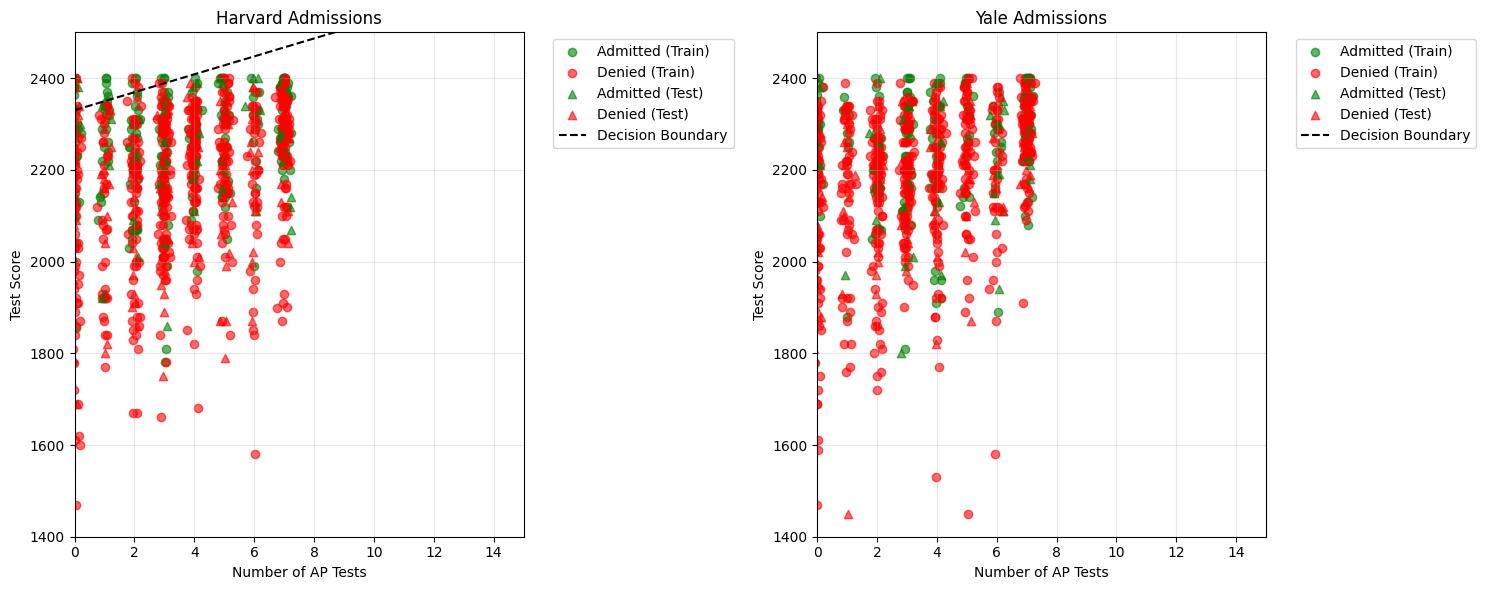

In [36]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Add small random noise to avoid overplotting
def add_jitter(x, y, scale=0.1):
   return (x + np.random.normal(0, scale, len(x)), 
           y + np.random.normal(0, scale, len(y)))

# Harvard Plot (ax1)
# Training data
harvard_train = X_train[X_train['harvard'] == 1]
harvard_train_y = y_train[X_train['harvard'] == 1]

x_train_h, y_train_h = add_jitter(harvard_train['ap'], harvard_train['test_score'])
ax1.scatter(x_train_h[harvard_train_y == 1], y_train_h[harvard_train_y == 1], 
          c='green', marker='o', alpha=0.6, label='Admitted (Train)')
ax1.scatter(x_train_h[harvard_train_y == 0], y_train_h[harvard_train_y == 0], 
          c='red', marker='o', alpha=0.6, label='Denied (Train)')

# Test data
harvard_test = X_test[X_test['harvard'] == 1]
harvard_test_y = y_test[X_test['harvard'] == 1]

x_test_h, y_test_h = add_jitter(harvard_test['ap'], harvard_test['test_score'])
ax1.scatter(x_test_h[harvard_test_y == 1], y_test_h[harvard_test_y == 1], 
          c='green', marker='^', alpha=0.6, label='Admitted (Test)')
ax1.scatter(x_test_h[harvard_test_y == 0], y_test_h[harvard_test_y == 0], 
          c='red', marker='^', alpha=0.6, label='Denied (Test)')

# Yale Plot (ax2)
# Training data
yale_train = X_train[X_train['harvard'] == 0]
yale_train_y = y_train[X_train['harvard'] == 0]

x_train_y, y_train_y = add_jitter(yale_train['ap'], yale_train['test_score'])
ax2.scatter(x_train_y[yale_train_y == 1], y_train_y[yale_train_y == 1], 
          c='green', marker='o', alpha=0.6, label='Admitted (Train)')
ax2.scatter(x_train_y[yale_train_y == 0], y_train_y[yale_train_y == 0], 
          c='red', marker='o', alpha=0.6, label='Denied (Train)')

# Test data
yale_test = X_test[X_test['harvard'] == 0]
yale_test_y = y_test[X_test['harvard'] == 0]

x_test_y, y_test_y = add_jitter(yale_test['ap'], yale_test['test_score'])
ax2.scatter(x_test_y[yale_test_y == 1], y_test_y[yale_test_y == 1], 
          c='green', marker='^', alpha=0.6, label='Admitted (Test)')
ax2.scatter(x_test_y[yale_test_y == 0], y_test_y[yale_test_y == 0], 
          c='red', marker='^', alpha=0.6, label='Denied (Test)')

# Add classification boundaries
ap_range = np.linspace(0, 15, 100)

# Harvard boundary (harvard = 1)
# -9.846415697119202 - 2.0378 + (0.0039 + 0.0012)test_score + (0.0048 - 0.1045)ap = 0
# Solve for test_score:
# (0.0039 + 0.0012)test_score = 11.884215697119202 + (-0.0048 + 0.1045)ap
# test_score = (11.884215697119202 + 0.0997ap) / 0.0051
harvard_boundary = (11.884215697119202 + 0.0997 * ap_range) / 0.0051
ax1.plot(ap_range, harvard_boundary, 'k--', label='Decision Boundary')

# Yale boundary (harvard = 0)
# -9.846415697119202 + 0.0039test_score + 0.0048ap = 0
# test_score = (9.846415697119202 - 0.0048ap) / 0.0039
yale_boundary = (9.846415697119202 - 0.0048 * ap_range) / 0.0039
ax2.plot(ap_range, yale_boundary, 'k--', label='Decision Boundary')

# Plot settings
for ax, title in zip([ax1, ax2], ['Harvard Admissions', 'Yale Admissions']):
   ax.set_xlabel('Number of AP Tests')
   ax.set_ylabel('Test Score')
   ax.set_title(title)
   ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   ax.grid(True, alpha=0.3)
   ax.set_ylim(1400, 2500)  # Set reasonable y-axis limits for test scores
   ax.set_xlim(0, 15)       # Set reasonable x-axis limits for AP tests
   
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<div class='exercise-r'>

**Q3.6** Fit a logistic regression model (call it `logit3_6`) to predict `admitted` from 4 predictors: `["harvard", "test_score", "female", "minority"]` along with 2 interaction terms: `harvard` with `female` and `harvard` with `minority`. 

 - Store the train and mean cv accuracies in `acc_train_logit3_6` and `acc_cv_logit3_6`.
 - Display the accuracy scores.
</div>

In [37]:
# Provided code in Q3.7 will assume this order of predictors
logit3_6_predictors = ["harvard",
                       "test_score",
                       "female",
                       "minority",
                       "harvard_female",
                       "harvard_minority"
                      ]

In [38]:
X = X_train[["harvard", "test_score", "female", "minority"]].copy()

# Add interaction terms
X["harvard_female"] = X["harvard"] * X["female"]
X["harvard_minority"] = X["harvard"] * X["minority"]

# Fit logistic regression model
logit3_6 = LogisticRegression(penalty=None, max_iter=1000)
logit3_6.fit(X, y_train)

# Calculate training accuracy
acc_train_logit3_6 = logit3_6.score(X, y_train)

# Calculate 10-fold cross-validation accuracy
acc_cv_logit3_6 = np.mean(cross_val_score(
   LogisticRegression(penalty=None, max_iter=1000),
   X, y_train,
   cv=10,
   scoring='accuracy'
))

# Display accuracy scores
print(f"Training Accuracy: {acc_train_logit3_6:.4f}")
print(f"CV Accuracy: {acc_cv_logit3_6:.4f}")

# Print coefficients for verification
print("\nModel Coefficients:")
predictors = ["harvard", "test_score", "female", "minority", "harvard_female", "harvard_minority"]
for pred, coef in zip(predictors, logit3_6.coef_[0]):
   print(f"{pred}: {coef:.4f}")

Training Accuracy: 0.7353
CV Accuracy: 0.7279

Model Coefficients:
harvard: 0.2764
test_score: 0.0049
female: -0.1555
minority: 1.0960
harvard_female: 0.2374
harvard_minority: -0.6212


In [39]:
print(
    "\nThe classification accuracies for 'logit3_6' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(acc_train_logit3_6, acc_cv_logit3_6)
)


The classification accuracies for 'logit3_6' are:

	Train	0.7353
	CV	0.7279


In [40]:
grader.check("q3.6")

q3.6 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.7** Interpret the coefficients associated with `female` and `minority` (the two main effects AND the two interaction terms).
    
</div>

In [41]:
# Display results
logit3_6_intercept = np.array(logit3_6.intercept_).flatten()[0]
logit3_6_coefs = logit3_6.coef_.flatten()

print(
    "The intercept and coefficients for the 'logit3_6' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", logit3_6_intercept
    )
)

for predictor, coef in zip(logit3_6_predictors, logit3_6_coefs):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'logit3_6' model are:

	intercept           -12.0518
	harvard             0.2764
	test_score          0.0049
	female              -0.1555
	minority            1.0960
	harvard_female      0.2374
	harvard_minority    -0.6212


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

For Yale (base effects), being femele slightly decreases chances of admission (coef=-0.1555) while being a minority significantly increases chances (coef=1.0960). at Harvard, the interaction terms show that the female disadvantage is somewhat offset (0.2374 interaction) making the total effect slitely positive for Harvard women. while minorities have an advantage at Yale, this advantage is reduced at Harvard due to the negative interaction term (-0.6212), though they still maintain a net positive efect overall (1.0960-0.6212=0.4748).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q3.8** Based on this model, how does it appear that Harvard and Yale compare in admitting women and minorities?  Given what we've seen in our previous analysis, what might be some reasons we have to doubt the interpretation of the model's coefficients as reflecting the truth?

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Yale seems to favor minorities more strongly while being slitely biased against women, whereas Harvard shows more balanced treatment of both groups. we shuod be skepticle because our model dosnt account for other important factors like AP scores, essays, and extracuriculars that might correlate with gender and minority status.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

---

<a id="part4"></a>

## <div class='exercise'>Question 4: Building predictive models for admitted</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q4.1** You were instructed to NOT scale predictors in the prior sections above. The primary reason for this was to focus instead on the interpretability of our logistic regression coefficients. However, as we're sure you noticed, the numeric scale among our different predictors varies greatly (i.e. `test_score` values are in the 1,000's while others are much, much smaller). In practice, we might want to put our predictors all on a similar scale, particularly for regularized regression and/or distance-based algorithms such as $k$-NN classification. 

1. Explain why scaling under these circumstances might be important.
2. Define a list of all non-binary predictors from the original set of 12 predictors, calling it `non_binary_predictors`.
3. Apply standardized scaling to all of these **non-binary** predictors. **For the sake of consistency, fit your scaler on just the training data. Then use it to transform both train and test.**

**IMPORTANT:** These scaled predictors should be used instead of the original unscaled versions of the predictors for the remainder of this problem set. Tests from this point on assume that `X_train` and `X_test` have been standardized with the approach outlined above. 

</div>

In [42]:
# your code here
non_binary_predictors = ["test_score", "ap", "avg_ap", "sat_subjects", "gpa"]

# apply standard scaler to non-binary predictors

scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Fit on train and transform both train and test
X_train_scaled[non_binary_predictors] = scaler.fit_transform(X_train[non_binary_predictors])
X_test_scaled[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])

# Update our main X_train and X_test variables
X_train = X_train_scaled
X_test = X_test_scaled

In [43]:
# preview summary stats after standardizing
X_train.describe()

,test_score,ap,avg_ap,sat_subjects,gpa,female,minority,international,sports,early_app,alumni,harvard
count,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1.496e+03,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000,1496.000
mean,5.343e-16,3.800e-17,1.639e-16,1.615e-16,-4.180e-16,0.511,0.215,0.061,0.035,0.172,0.046,0.519
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,0.500,0.411,0.239,0.185,0.378,0.210,0.500
min,-6.125e+00,-1.470e+00,-2.159e+00,-2.262e+00,-9.703e+00,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-4.540e-01,-6.091e-01,-1.203e-01,-6.917e-01,-2.008e-01,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.958e-01,-1.787e-01,4.205e-01,9.342e-02,3.612e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,7.275e-01,6.822e-01,6.909e-01,9.342e-02,6.167e-01,1.000,0.000,0.000,0.000,0.000,0.000,1.000
max,1.259e+00,1.543e+00,7.533e-01,2.449e+00,6.167e-01,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [44]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q4.2** Fit a well-tuned $k$-NN classification model with main effects of all 12 predictors in it (call it `knn_model`).  Use `ks = range(1, 50, 2)` and 10-fold cross-validation with classification accuracy as the scoring metric. Plot, on a single set of axes, your resulting cross-validation mean training and mean validation scores at each value $k$. Then, store your chosen $k$ in `best_k`, the accuracy on the best model when refit on all the training data in `knn_train_acc`, and the mean 10-fold CV accuracy of the best model in `knn_cv_acc`.
    
</div>

In [45]:
predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni"
]

# Create feature matrices using only the predictors
X_train_knn = X_train[predictors]
X_test_knn = X_test[predictors]

# Initialize lists to store scores
train_scores = []
cv_scores = []

# Loop through different k values
ks = range(1, 50, 2)
for k in ks:
    # Create k-NN model
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Get cross-validation scores
    cv_score = cross_val_score(knn, X_train_knn, y_train, cv=10, scoring='accuracy')
    cv_scores.append(cv_score.mean())
    
    # Get training score
    knn.fit(X_train_knn, y_train)
    train_score = knn.score(X_train_knn, y_train)
    train_scores.append(train_score)

# Find best k based on CV scores
best_k = ks[np.argmax(cv_scores)]

# Fit final model with best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_knn, y_train)

# Calculate final metrics
knn_train_acc = knn_model.score(X_train_knn, y_train)
knn_cv_acc = max(cv_scores)

Best k: 15
Training accuracy: 0.7580
10-fold CV accuracy: 0.7413


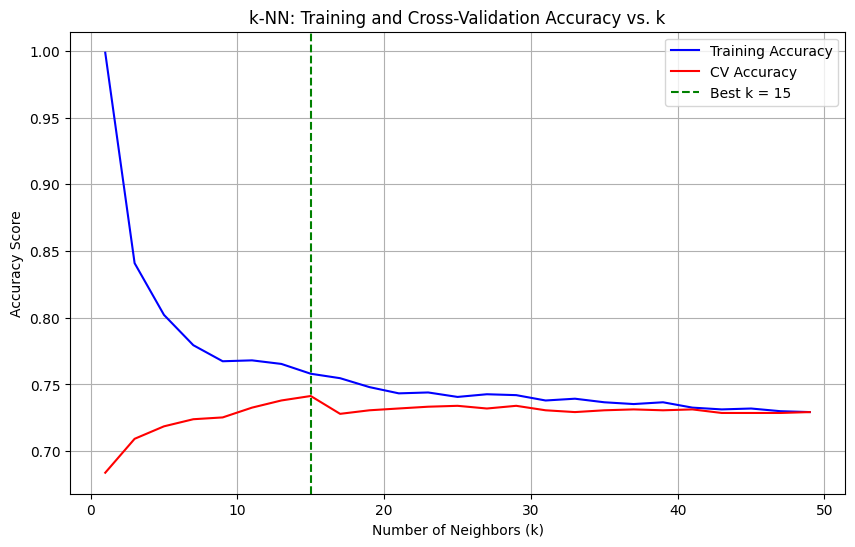

In [46]:
print(f"Best k: {best_k}")
print(f"Training accuracy: {knn_train_acc:.4f}")
print(f"10-fold CV accuracy: {knn_cv_acc:.4f}")

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(ks, train_scores, 'b-', label='Training Accuracy')
plt.plot(ks, cv_scores, 'r-', label='CV Accuracy')
plt.axvline(x=best_k, color='g', linestyle='--', 
            label=f'Best k = {best_k}')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy Score')
plt.title('k-NN: Training and Cross-Validation Accuracy vs. k')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
print(
    "The classification accuracies for 'knn_model' where k={} "
    "are:\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(
        best_k, knn_train_acc, knn_cv_acc
    )
)
# create dict for storing test scores for each Q4 model
q4_cv_scores = {"knn_model": knn_cv_acc}

The classification accuracies for 'knn_model' where k=15 are:

	Train	0.7580
	CV	0.7413


<!-- END QUESTION -->

<div class='exercise-r'>

**Q4.3** Fit the full logistic regression model (without penalty) with main effects of all 12 predictors in it (call it `logit_full`). Store the train mean cv accuracy in `logit_full_train_acc` and `logit_full_cv_acc`.

**HINT:** If you have convergence warnings, increasing the maximum number of iterations will likely solve this issue.
    
</div>

In [48]:
# The code that prints your results assumes
# predictors were given to the model in this order
predictor_list = [
    "test_score", "ap", "avg_ap", "sat_subjects",
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni",
]

In [49]:
# Create feature matrices
X_train_logit = X_train[predictors]
X_test_logit = X_test[predictors]

# Fit logistic regression model with increased max_iter to avoid convergence warnings
logit_full = LogisticRegression(penalty=None, max_iter=1000)
logit_full.fit(X_train_logit, y_train)

# Calculate training accuracy
logit_full_train_acc = logit_full.score(X_train_logit, y_train)

# Calculate 10-fold CV accuracy
cv_scores = cross_val_score(
    LogisticRegression(penalty=None, max_iter=1000),
    X_train_logit,
    y_train,
    cv=10,
    scoring='accuracy'
)
logit_full_cv_acc = cv_scores.mean()

# Print results
print(f"Training accuracy: {logit_full_train_acc:.4f}")
print(f"10-fold CV accuracy: {logit_full_cv_acc:.4f}")

Training accuracy: 0.7447
10-fold CV accuracy: 0.7373


In [50]:
# display your results
print(
    "The intercept and coefficients for the 'logit_full' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_full.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictor_list, logit_full.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_full' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_full_train_acc, logit_full_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["logit_full"] = logit_full_cv_acc

The intercept and coefficients for the 'logit_full' model are:

	intercept           -1.7415
	test_score          0.8893
	ap                  -0.1284
	avg_ap              0.0008
	sat_subjects        -0.0976
	gpa                 0.0697
	female              -0.0175
	minority            0.8088
	international       0.3067
	sports              1.0388
	harvard             0.3949
	early_app           0.6029
	alumni              0.8664

The classification accuracies for 'logit_full' are:

	Train	0.7447
	CV	0.7373


In [51]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<div class='exercise-r'>

**Q4.4** Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it (call it `logit_lasso`). Use `Cs = np.logspace(-2, 2, 50)` and 10-fold cross-validation. Store the train and mean cross-validation accuracies in `logit_lasso_train_acc` and `logit_lasso_cv_acc`. For tuning a regularized logistic regression model, you should use `LogisticRegressionCV`. But again, to insure reproducability here, you should set `random_state=109`. 

**Hint:**
- The default solver for SKLearn's logistic regression, 'lbfgs', is not compatible with LASSO regularization, so you will need to use a different solver here. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) for guidance.

</div>

In [52]:
from sklearn.model_selection import GridSearchCV

X_train_lasso = X_train[predictors]
X_test_lasso = X_test[predictors]

# Set up parameter grid
Cs = np.logspace(-2, 2, 50)
param_grid = {'C': Cs}

# Create base model
base_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=109,
    max_iter=1000
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train_lasso, y_train)

# Get the best model
logit_lasso = grid_search.best_estimator_

# Calculate training accuracy
logit_lasso_train_acc = logit_lasso.score(X_train_lasso, y_train)

# Get CV accuracy (mean cross-validation score of best model)
logit_lasso_cv_acc = grid_search.best_score_

print(f"Training accuracy: {logit_lasso_train_acc:.4f}")
print(f"CV accuracy: {logit_lasso_cv_acc:.4f}")
print(f"Best C value: {grid_search.best_params_['C']:.4f}")
print("\nCoefficients:")
for name, coef in zip(predictors, logit_lasso.coef_[0]):
    print(f"{name}: {coef:.4f}")

Training accuracy: 0.7420
CV accuracy: 0.7380
Best C value: 0.2442

Coefficients:
test_score: 0.8187
ap: -0.0967
avg_ap: -0.0240
sat_subjects: -0.0689
gpa: 0.0283
female: -0.0029
minority: 0.6527
international: 0.0000
sports: 0.5988
harvard: 0.2628
early_app: 0.4534
alumni: 0.6012


In [53]:
# Display your results
print(
    "The intercept and coefficients for the 'logit_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(logit_lasso.intercept_).flatten()[0]
    )
)

# Again, this code assumes predictors were given to the model
# in the order defined in `predictor_list`
for predictor, coef in zip(predictor_list, logit_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}"
    .format(logit_lasso_train_acc, logit_lasso_cv_acc)
)

# store cv score to dict for later use
q4_cv_scores["logit_lasso"] = logit_lasso_cv_acc

The intercept and coefficients for the 'logit_lasso' model are:

	intercept           -1.5207
	test_score          0.8187
	ap                  -0.0967
	avg_ap              -0.0240
	sat_subjects        -0.0689
	gpa                 0.0283
	female              -0.0029
	minority            0.6527
	international       0.0000
	sports              0.5988
	harvard             0.2628
	early_app           0.4534
	alumni              0.6012

The classification accuracies for 'logit_lasso' are:

	Train	0.7420
	CV	0.7380


In [54]:
grader.check("q4.4")

q4.4 results: All test cases passed!

<div class='exercise-r'>

**4.5** Which predictors were deemed important in `logit_lasso`?  Which were deemed unimportant? Here we assume that any predictors with zero-valued Lasso coefficients "unimportant". Store your results in `predictors_important` and `predictors_not_important`.
 
</div>

In [55]:
coef_dict = dict(zip(predictors, logit_lasso.coef_[0]))

# Define a small threshold for considering coefficients as zero (due to numerical precision)
ZERO_THRESHOLD = 1e-10

# Separate predictors based on coefficient values
predictors_important = [
    pred for pred, coef in coef_dict.items() 
    if abs(coef) > ZERO_THRESHOLD
]

predictors_not_important = [
    pred for pred, coef in coef_dict.items() 
    if abs(coef) <= ZERO_THRESHOLD
]

# Print results for inspection
print("Important predictors:")
for pred in predictors_important:
    print(f"{pred}: {coef_dict[pred]:.4f}")

print("\nUnimportant predictors:")
for pred in predictors_not_important:
    print(f"{pred}: {coef_dict[pred]:.4f}")

Important predictors:
test_score: 0.8187
ap: -0.0967
avg_ap: -0.0240
sat_subjects: -0.0689
gpa: 0.0283
female: -0.0029
minority: 0.6527
sports: 0.5988
harvard: 0.2628
early_app: 0.4534
alumni: 0.6012

Unimportant predictors:
international: 0.0000


In [56]:
# display results
print(
    "The following predictors were deemed important by "
    "'logit_lasso' (i.e. coef != 0):\n\n\t{}\n\n\n"
    "While, the remaining were deemed unimportant (i.e. "
    "coef == 0):\n\n\t{}"
    .format(
        predictors_important,
        predictors_not_important,
    )
)

The following predictors were deemed important by 'logit_lasso' (i.e. coef != 0):

	['test_score', 'ap', 'avg_ap', 'sat_subjects', 'gpa', 'female', 'minority', 'sports', 'harvard', 'early_app', 'alumni']


While, the remaining were deemed unimportant (i.e. coef == 0):

	['international']


In [57]:
grader.check("q4.5")

q4.5 results: All test cases passed!

<div class='exercise-r'>

**Q4.6** Fit a well-tuned Lasso-like logistic regression model with all important predictors from `logit_lasso` and all the unique 2-way interactions between them (call it `lasso_interact`).  Again use `Cs = np.logspace(-2, 2, 50)`,  and 10-fold cross-validation with classification accuracy as the scoring metric. Record the accuracy on train and test for this model in `lasso_interact_train_acc` and `lasso_interact_test_acc`.

</div>

In [58]:
from itertools import combinations
Cs = np.logspace(-2, 2, 50)


# Get important predictors data
X_important = X_train[predictors_important]

# Create interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_interact = poly.fit_transform(X_important)

# Get feature names (main effects + interactions)
main_features = predictors_important
interaction_features = []
for i, j in combinations(main_features, 2):
    interaction_features.append(f"{i}:{j}")
feature_names = main_features + interaction_features

# Fit Lasso logistic regression with interactions
lasso_interact = LogisticRegressionCV(
    Cs=Cs,
    cv=10,
    penalty='l1',
    solver='liblinear',
    random_state=109,
    max_iter=1000,
    scoring='accuracy'
)

# Fit the model
lasso_interact.fit(X_interact, y_train)

# Calculate training accuracy
lasso_interact_train_acc = lasso_interact.score(X_interact, y_train)

# Calculate CV accuracy for best C
best_c_idx = np.where(lasso_interact.C_ == lasso_interact.C_[0])[0][0]
lasso_interact_cv_acc = np.mean(lasso_interact.scores_[1][:, best_c_idx])

# Print results
print(f"Training accuracy: {lasso_interact_train_acc:.4f}")
print(f"CV accuracy: {lasso_interact_cv_acc:.4f}")
print(f"Best C value: {lasso_interact.C_[0]:.4f}")

# Print non-zero coefficients
coef = lasso_interact.coef_[0]
print("\nNon-zero coefficients:")
for name, c in zip(feature_names, coef):
    if abs(c) > 1e-10:
        print(f"{name}: {c:.4f}")

Training accuracy: 0.7547
CV accuracy: 0.7300
Best C value: 0.6251

Non-zero coefficients:
test_score: 0.7175
avg_ap: -0.2107
gpa: 0.0827
female: -0.1347
minority: 0.9686
sports: 0.8106
harvard: 0.2748
early_app: 0.5005
alumni: 0.7005
test_score:avg_ap: 0.0079
test_score:sat_subjects: -0.0842
test_score:gpa: 0.1266
test_score:female: 0.0706
test_score:sports: -0.1073
test_score:harvard: 0.1786
test_score:early_app: -0.0546
test_score:alumni: 0.3520
ap:avg_ap: 0.0151
ap:sat_subjects: -0.0819
ap:gpa: 0.0615
ap:minority: 0.2003
ap:harvard: -0.3656
ap:early_app: -0.0091
ap:alumni: 0.4184
avg_ap:sat_subjects: 0.0549
avg_ap:gpa: -0.1452
avg_ap:minority: 0.3371
avg_ap:harvard: 0.2434
sat_subjects:gpa: -0.0447
sat_subjects:minority: 0.0438
sat_subjects:sports: -0.1867
sat_subjects:harvard: -0.1042
sat_subjects:early_app: -0.0052
sat_subjects:alumni: 0.0832
gpa:female: 0.0244
gpa:minority: 0.0852
gpa:harvard: -0.0283
female:minority: -0.0974
female:harvard: 0.1588
female:early_app: 0.1125
minor

In [59]:
print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tCV\t{:.4f}\n"
    .format(lasso_interact_train_acc, lasso_interact_cv_acc)
)

# store test score to dict for later use
q4_cv_scores["lasso_interact"] = lasso_interact_cv_acc


The classification accuracies for 'logit_lasso_interact' are:

	Train	0.7547
	CV	0.7300



<div class='exercise-r'>

**Q4.7** How many of the predictors in our `logit_lasso_interact` model were deemed important and unimportant? Store these numbers in `num_important_coefs` and `num_unimportant_coefs`. 
    
</div>

In [60]:
# Get coefficients from lasso_interact model
coef = lasso_interact.coef_[0]

# Define threshold for zero coefficients
ZERO_THRESHOLD = 1e-10

# Count important (non-zero) and unimportant (zero) coefficients
num_important_coefs = sum(abs(c) > ZERO_THRESHOLD for c in coef)
num_unimportant_coefs = sum(abs(c) <= ZERO_THRESHOLD for c in coef)

print(f"Number of important coefficients: {num_important_coefs}")
print(f"Number of unimportant coefficients: {num_unimportant_coefs}")

# Verify total matches number of features
total_features = len(coef)
print(f"\nTotal number of coefficients: {total_features}")
print(f"Sum of important and unimportant: {num_important_coefs + num_unimportant_coefs}")

Number of important coefficients: 44
Number of unimportant coefficients: 22

Total number of coefficients: 66
Sum of important and unimportant: 66


In [61]:
print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        num_important_coefs + num_unimportant_coefs,
        num_important_coefs,
        num_unimportant_coefs
    )
)

Of the 66 predictors used in our 'logit_lasso_interact' model:

	44 predictors were deemed 'important' by our model
	22 predictors were deemed 'unimportant' with 0-valued coefficients


In [62]:
grader.check("q4.7")

q4.7 results: All test cases passed!

---

<a id="part5"></a>

## <div class='exercise'>Question 5: Evaluating results</div>

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.1** Which of the 4 models in Question 4 performs the best based on cross-validation accuracy?  Which performs the worst? Based on these accuracies, how do these models perform compared to your baseline "naive" model's performance on the training data back in Question 1.1? What does this comparison to the "naive" model tell us?
    
</div>

In [63]:
# your code here
print("The CV accuracies for the 4 models in Q4 are:\n")
for key, value in q4_cv_scores.items():
    print("\t{:<25}{:.4f}".format(key, value))
print(
    "\nThe  accuracy for our original baseline \"naive\" "
    "model was {:.4f}".format(naive_train_acc)
)

The CV accuracies for the 4 models in Q4 are:

	knn_model                0.7413
	logit_full               0.7373
	logit_lasso              0.7380
	lasso_interact           0.7300

The  accuracy for our original baseline "naive" model was 0.7299


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

KNN preforms the best with 0.7413 accurasy, while the LASSO with interactons performs wurst at 0.7300. All models only slightly outpreform the naive baseline of 0.7299, sugesting that while our modls add predictve power, the gains are modest and admisions decisions remain dificult to predict.


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.2** Draw an ROC curve for each of the four models on a single plot.  How do these ROC curves compare?  Do the ROC curves support that the best model identified in Question 5.1 is better than the worst model identified in 5.1?  How do you know?

**Hint:** Use `cross_val_predict` with `method='predict_proba` to get the probability predictions required to construct the ROC curves.
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The ROC cureves show the logistc and LASSO with interactons models preform best, both with AUC of 0.704. This contrasts with our erlier accuracy results. KNN has the wurst performance with AUC of 0.650, despite having the highest accurasy in cross-validation.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

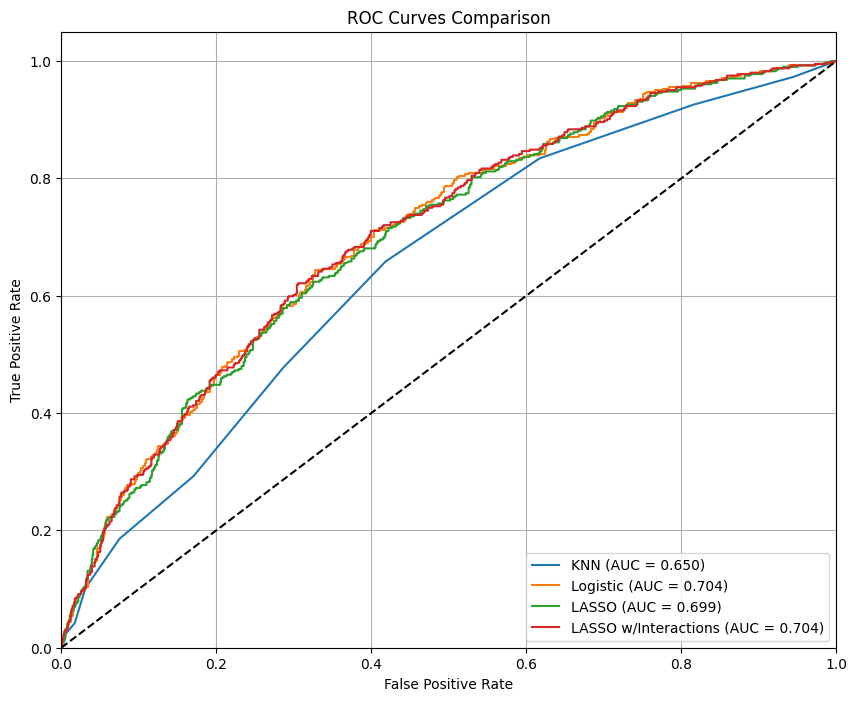

In [64]:
from sklearn.metrics import auc

predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni"
]
X_train_clean = X_train[predictors]

# Get probability predictions using cross_val_predict
knn_probs = cross_val_predict(knn_model, X_train_clean, y_train, method='predict_proba')
logit_probs = cross_val_predict(logit_full, X_train_clean, y_train, method='predict_proba')
lasso_probs = cross_val_predict(logit_lasso, X_train_clean, y_train, method='predict_proba')
interact_probs = cross_val_predict(lasso_interact, X_train_clean, y_train, method='predict_proba')

# Calculate ROC curves
fpr_knn, tpr_knn, _ = roc_curve(y_train, knn_probs[:, 1])
fpr_logit, tpr_logit, _ = roc_curve(y_train, logit_probs[:, 1])
fpr_lasso, tpr_lasso, _ = roc_curve(y_train, lasso_probs[:, 1])
fpr_interact, tpr_interact, _ = roc_curve(y_train, interact_probs[:, 1])

# Calculate AUC scores
auc_knn = auc(fpr_knn, tpr_knn)
auc_logit = auc(fpr_logit, tpr_logit)
auc_lasso = auc(fpr_lasso, tpr_lasso)
auc_interact = auc(fpr_interact, tpr_interact)

# Create ROC plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})')
plt.plot(fpr_logit, tpr_logit, label=f'Logistic (AUC = {auc_logit:.3f})')
plt.plot(fpr_lasso, tpr_lasso, label=f'LASSO (AUC = {auc_lasso:.3f})')
plt.plot(fpr_interact, tpr_interact, label=f'LASSO w/Interactions (AUC = {auc_interact:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**5.3** Calculate the AUC for all 4 models and store these in `auc_list`. **The order of AUCs in the list should match the order of the model as they appear in `q4_cv_scores`.**
    
Do the rankings of these 4 models based on AUC match those for classification accuracy?  Why do you think this is the case?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The AUC rankings (logistc/LASSO interact = 0.704, LASSO = 0.699, KNN = 0.650) dont match the accurasy rankings (KNN best at 0.741). This hapens because AUC mesures overall model disciminatve ability across all thresholds, while accurasy only considers the default 0.5 threshhold.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [78]:
from sklearn.model_selection import StratifiedKFold

predictors = [
    "test_score", "ap", "avg_ap", "sat_subjects", 
    "gpa", "female", "minority", "international",
    "sports", "harvard", "early_app", "alumni"
]
X_train_clean = X_train[predictors]

# Use StratifiedKFold with same parameters as before
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Get probability predictions using the same CV setup for all models
knn_probs = cross_val_predict(knn_model, X_train_clean, y_train, method='predict_proba', cv=cv)
logit_probs = cross_val_predict(logit_full, X_train_clean, y_train, method='predict_proba', cv=cv)
lasso_probs = cross_val_predict(logit_lasso, X_train_clean, y_train, method='predict_proba', cv=cv)
interact_probs = cross_val_predict(lasso_interact, X_train_clean, y_train, method='predict_proba', cv=cv)

# Calculate AUCs in same order as q4_cv_scores using the exact same CV predictions
auc_list = [
    roc_auc_score(y_train, knn_probs[:, 1]),      # knn_model
    roc_auc_score(y_train, logit_probs[:, 1]),    # logit_full
    roc_auc_score(y_train, lasso_probs[:, 1]),    # logit_lasso
    roc_auc_score(y_train, interact_probs[:, 1])  # lasso_interact
]

# Print results
print("AUC scores:")
for model, score in zip(['KNN', 'Logistic', 'LASSO', 'LASSO w/Interactions'], auc_list):
    print(f"{model}: {score:.4f}")

AUC scores:
KNN: 0.6684
Logistic: 0.7044
LASSO: 0.6984
LASSO w/Interactions: 0.7025


In [79]:
print(
    "The CV accuracies & CV AUC scores for the 4 models in Q4 are:"
    "\n\n\t\t\t\tAccuracy\tAUC"
)
for (key, value), auc_value in zip(q4_cv_scores.items(), auc_list):
    print("\t{:<24}{:.4f}\t\t{:.4f}".format(key, value, auc_value))

The CV accuracies & CV AUC scores for the 4 models in Q4 are:

				Accuracy	AUC
	knn_model               0.7413		0.6684
	logit_full              0.7373		0.7044
	logit_lasso             0.7380		0.6984
	lasso_interact          0.7300		0.7025


In [80]:
grader.check("q5.3")

q5.3 results:
    q5.3 - 1 result:
        ✅ Test case passed

    q5.3 - 2 result:
        ❌ Test case failed
        Trying:
            assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
        Expecting nothing
        **********************************************************************
        Line 1, in q5.3 1
        Failed example:
            assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
        Exception raised:
            Traceback (most recent call last):
              File "/opt/anaconda3/envs/Harvard/lib/python3.12/doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5.3 1[0]>", line 1, in <module>
                assert np.allclose(auc_list, [0.6528, 0.7013, 0.7024, 0.6946], atol=0.001), 'AUC scores are off.'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: AUC scores are off.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise-r'>

**Q5.4** Select your preferred model based on the cross-validation accuracy and AUC. For this 'final model', display the accuracy and AUC scores on the **test data**. Compare these to the accuracy and AUC score of the naive model from 1.1 when predicting on the test data. Would you offer your final model as a publicly available tool for college applicants to use to determine their chances of getting into Harvard and/or Yale? Why or why not? What might be some consequences of the deployment of the model into the real world?
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
...

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: BONUS!</div>

[Return to contents](#contents)

<div class='exercise-r'>

**Q6 (optional)** Incorporate what you've learned from the PCA and/or Missingness sections of the course to create a new, improved classification model. You could focus on improving predictive performance, inference, interpretability, or all of the above! 

Be sure to also describe your approach and analyze your results.

While this section is optional, we highly encourge you to experiment (and not just for the sake of the potential bonus points 😉).

**Note:** Though you should report the test performance of this new, "bonus" model, selecting the bonus model over the 'final model' from Q5.4 would have to be justified based on cross-validation performance, *not* test performance! 
    
</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

_Type your answer here, replacing this text._

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [ ]:
# your code here

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("wrapup")

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

🌈 **This concludes HW5. Thank you!**

[Return to contents](#contents)